# Autoregressive Integrated Moving Averages

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Augmented Dickey Fuller Test

In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [4]:
# Load datasets
df1 = pd.read_csv('../DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months
df1

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-04-26,35
1959-04-27,40
1959-04-28,42


In [5]:
df2 = pd.read_csv('../TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'
df2

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


---
# EDA 
---

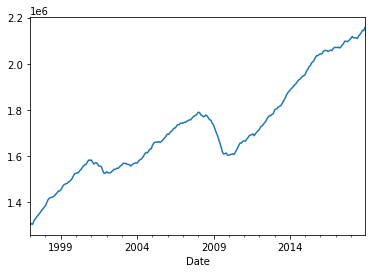

In [6]:
df2['Inventories'].plot()
plt.show()

### Run an ETS Decomposition (optional)

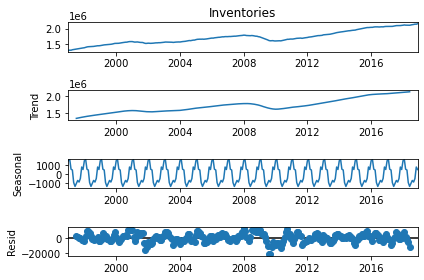

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

### Check stationarity using Dickey-Fuller Test

In [8]:
adf_test(df2['Inventories'])

Fail to reject the null hypothesis
Data is non-stationary


### Do first order differencing - (optional)

In [9]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)
adf_test(df2['d1'])

Reject the null hypothesis
Data is stationary


In [10]:
len(df2)

264

In [11]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

### Fit an ARIMA(1,1,1) Model

In [12]:
from statsmodels.tsa.arima_model import ARIMA

In [13]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Sun, 11 Jul 2021   AIC                           4980.790
Time:                        21:51:35   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.871      2.378      0.017     561.672    5833.468
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

### Use model to predict

In [14]:
# Obtain predicted values
start=len(train)
end=len(df2)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(1,1,1) Predictions')

In [15]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2107148.333, expected=2110158
predicted=2110526.2  , expected=2118199
predicted=2113886.498, expected=2112427
predicted=2117230.939, expected=2112276
predicted=2120561.069, expected=2111835
predicted=2123878.282, expected=2109298
predicted=2127183.836, expected=2119618
predicted=2130478.868, expected=2127170
predicted=2133764.403, expected=2134172
predicted=2137041.366, expected=2144639
predicted=2140310.593, expected=2143001
predicted=2143572.837, expected=2158115


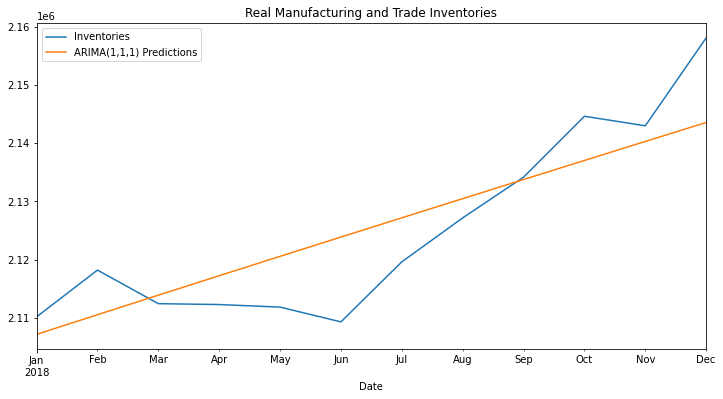

In [16]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Inventories'
xlabel='' 

test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
plt.show()

### Evaluate the Model

In [17]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
error.round(2)

60677823.82

In [18]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
error.round(2)

7789.6

### Retrain the model on the full data, and forecast the future

In [19]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

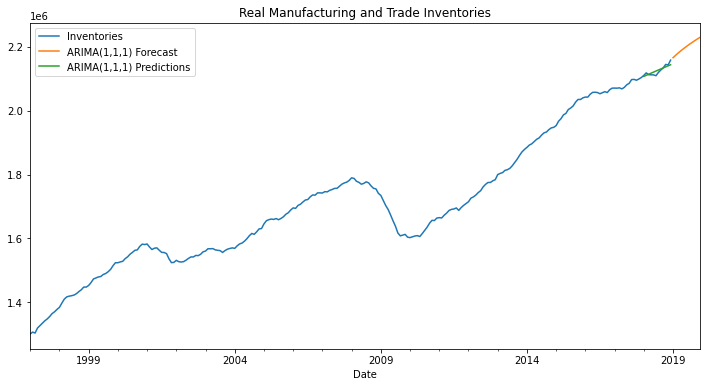

In [20]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Inventories'
xlabel='Period' 

df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
predictions.plot(legend=True)
plt.show()